In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from uncertainty_forest.uncertainty_forest import UncertaintyForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from scipy.stats import entropy, norm
from scipy.integrate import quad

In [2]:
def generate_data(n, d, frac_eval, mu = 1):
    n_1 = np.random.binomial(n, .5) # number of class 1
    mean = np.zeros(d)
    mean[0] = mu
    X_1 = np.random.multivariate_normal(mean, np.eye(d), n_1)
    
    X = np.concatenate((X_1, np.random.multivariate_normal(-mean, np.eye(d), n - n_1)))
    y = np.concatenate((np.repeat(1, n_1), np.repeat(-1, n - n_1)))
  
    return X, y

def split_train_eval(X, y, frac_eval):
    
    if frac_eval == 0:
        return X, y, [], []
    
    n = len(y)
    n_eval = int(np.floor(frac_eval*n))
    eval_indices = np.random.choice(np.arange(n), size = n_eval, replace = False)
    X_eval = X[eval_indices, :]
    y_eval = y[eval_indices]
    X = np.delete(X, eval_indices, axis = 0)
    y = np.delete(y, eval_indices, axis = 0)
    
    return X, y, X_eval, y_eval

In [3]:
def conditional_entropy_distribution(n, d, frac_eval, algos, num_trials, mu, parallel = False):
    # For each trial, generate data and compute conditional entropy for each algorithm.
    def worker(t):
        # X, y, X_eval = generate_data(n, d, frac_eval, mu = mu)
        X, y = generate_data(n, d, 0, mu = mu)
        ret = np.zeros(len(algos))
        for i in range(len(algos)):
            obj = algos[i]['instance']
            if algos[i]['label'] == 'UF':
                obj.fit(X, y)
                ret[i] = obj.estimate_cond_entropy()
            else:
                X, y, X_eval, y_eval = split_train_eval(X, y, frac_eval)
                obj.fit(X, y)
                p = obj.predict_proba(X_eval)
                ret[i] = np.mean(entropy(p.T, base = 2))
        return ret
    
    if parallel:
        predicted_cond_entropy = np.array(Parallel(n_jobs=-2)(delayed(worker)(t) for t in range(num_trials)))
    else:
        predicted_cond_entropy = np.zeros((num_trials, len(algos)))
        for t in tqdm(range(num_trials)):
            predicted_cond_entropy[t, :] = worker(t)
            
    return predicted_cond_entropy

In [4]:
def true_cond_entropy(mu):
    def func(x):
        p = 0.5 * norm.pdf(x, mu, 1) + 0.5 * norm.pdf(x, -mu, 1)
        return -p * np.log2(p)
    
    H_X = quad(func, -20, 20)
    H_XY = 0.5*(1.0/np.log(2.0) + np.log2(2 * np.pi))
    H_Y = 1
    # I_XY = H_X - H_XY = H_Y - H_YX
    return H_Y - H_X[0] + H_XY

In [5]:
def conditional_entropy_by_d(n, ds, frac_eval, algos, num_trials, mu, parallel = False):
    # Repeat for all 'd', and save output in the 'algos' array.
    cond_entropy_range = np.zeros((len(ds), num_trials, len(algos)))
    for i in range(len(ds)):
        cond_entropy_range[i, :, :] = conditional_entropy_distribution(n, 
                                                                       ds[i], 
                                                                       frac_eval, 
                                                                       algos, 
                                                                       num_trials, 
                                                                       mu,
                                                                       parallel = parallel)
        
    for j in range(len(algos)):
        algos[j]['cond_entropy_by_d_n_%d' % n] = cond_entropy_range[:, :, j]
        
    with open('algos_fig2.pkl', 'wb') as f:
        pickle.dump(algos, f)
    with open('ds_n_%d.pkl' % n, 'wb') as f:
        pickle.dump(ds, f)

In [6]:
def plot_cond_entropy_by_d(ax, num_plotted_trials, n, mu = 1):
    with open('ds_n_%d.pkl' % n, 'rb') as f:
        ds = pickle.load(f)
    with open('algos_fig2.pkl', 'rb') as f:
        algos = pickle.load(f)
    
    for algo in algos:
        # Plot the mean over trials as a solid line.
        ax.plot(ds,
                np.mean(algo['cond_entropy_by_d_n_%d' % n], axis = 1).flatten(), 
                label = algo['label'], 
                linewidth = 3, 
                color = algo['color'])
        # Use transparent lines to show other trials.
        for t in range(num_plotted_trials):
            ax.plot(ds, 
                    algo['cond_entropy_by_d_n_%d' % n][:, t].flatten(),  
                    linewidth = 1.5, 
                    color = algo['color'],
                    alpha = 0.15)
    
    truth = true_cond_entropy(mu)
    ax.axhline(y = truth, linestyle = '-', color = "black", label = "Truth")
            
    ax.set_xlabel("Dimensionality")
    ax.set_ylabel("Estimated Conditional Entropy")
    ax.set_title("Effect Size = %.1f, n = %d" % (mu, n))
    ax.set_ylim(ymin = -0.05, ymax = 1.05)

In [7]:
def plot_fig7(num_plotted_trials, n0, n1, n2):
    sns.set(font_scale = 1.5)
    sns.set_style("ticks")
    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams['figure.figsize'] = [8, 20]
    fig, axes = plt.subplots(3, 1)
    
    plot_cond_entropy_by_d(axes[0], num_plotted_trials, n0)
    plot_cond_entropy_by_d(axes[1], num_plotted_trials, n1)
    plot_cond_entropy_by_d(axes[2], num_plotted_trials, n2)
                                                  
    axes[0].legend(loc = "upper left")
    
    plt.tight_layout()
    plt.savefig("fig7.pdf")
    plt.show()

In [8]:
# Data.
n_estimators = 300
frac_eval = 0.3
mu = 1
ds = range(1, 21)
n0 = 1000
n1 = 5000
n2 = 10000
num_trials = 40
num_plotted_trials = 10
parallel = True

# Algorithms.
algos = [
    {
        'instance': RandomForestClassifier(n_estimators = n_estimators),
        'label': 'CART',
        'title': 'CART Forest',
        'color': "#1b9e77",
    },
    {
        'instance': CalibratedClassifierCV(base_estimator=RandomForestClassifier(n_estimators = n_estimators), 
                                           method='isotonic', 
                                           cv = 5),
        'label': 'IRF',
        'title': 'Isotonic Reg. Forest',
        'color': "#fdae61",
    },
    {
        'instance': UncertaintyForest(n_estimators = n_estimators),
        'label': 'UF',
        'title': 'Uncertainty Forest',
        'color': "#F41711",
    },
]

In [9]:
conditional_entropy_by_d(n0, ds, frac_eval, algos, num_trials, mu, parallel = parallel)

In [10]:
conditional_entropy_by_d(n1, ds, frac_eval, algos, num_trials, mu, parallel = parallel)

In [11]:
conditional_entropy_by_d(n2, ds, frac_eval, algos, num_trials, mu, parallel = parallel)

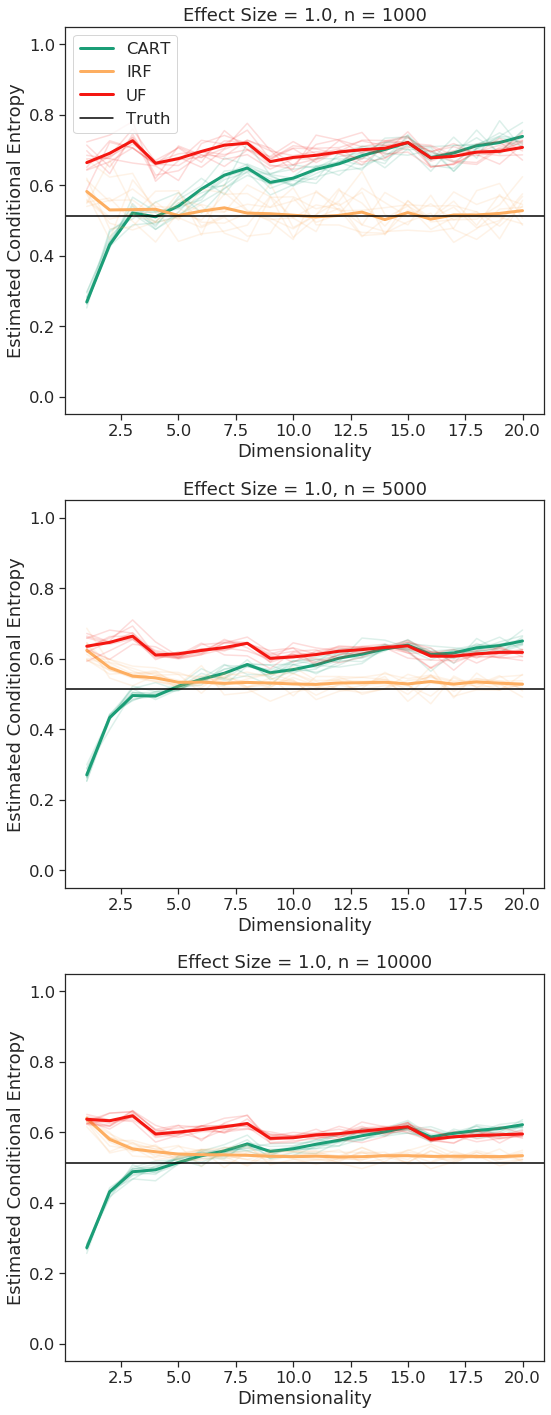

In [12]:
plot_fig7(num_plotted_trials, n0, n1, n2)